In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 3.9 MB/s 
     |████████████████████████████████| 9.8 MB 42.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Base de dados

https://www.kaggle.com/code/ranja7/predict-future-sales/data?select=sales_train.csv

https://www.kaggle.com/code/ranja7/predict-future-sales/data?select=sales_train.csv

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sales_train.csv')
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [6]:
df_train.shape

(2935849, 6)

In [8]:
df_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [14]:
df_train['date'] = df_train['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

TypeError: ignored

In [15]:
df_train['month'] = df_train['date'].dt.to_period('M')
df_train['month'] = df_train['month'].astype(str)
df_train['month'] = pd.to_datetime(df_train['month'])
df_train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
month             datetime64[ns]
dtype: object

In [16]:
dff_train = df_train.groupby(['month']).agg({'item_cnt_day':'sum'})
dff_train['month'] = dff_train.index
dff_train.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
print(dff_train.shape, dff_train.columns)

(34, 2) Index(['item_cnt_month', 'month'], dtype='object')


In [17]:
len(dff_train.drop(['month'], axis = 1))

34

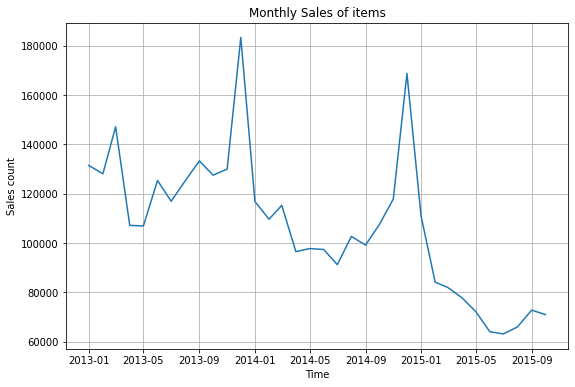

In [18]:
plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(dff_train['item_cnt_month'])
plt.title('Monthly Sales of items')
plt.xlabel('Time')
plt.ylabel('Sales count')
plt.show()

Autocorrelation = 0.6636


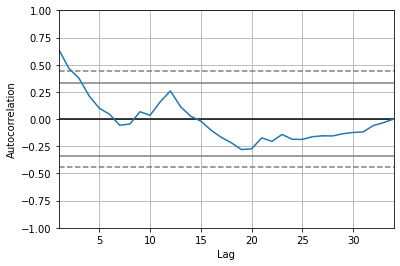

In [19]:
pd.plotting.autocorrelation_plot(dff_train['item_cnt_month'])
print('Autocorrelation =', round(dff_train['item_cnt_month'].autocorr(), 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


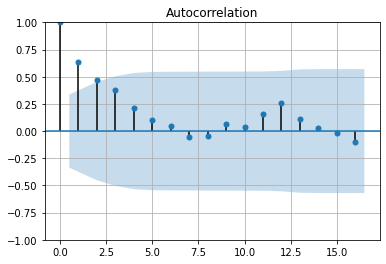

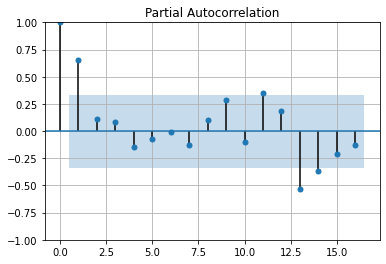

In [20]:
plot_acf(dff_train['item_cnt_month'])
plt.grid()
plot_pacf(dff_train['item_cnt_month'])
plt.grid()
plt.show()

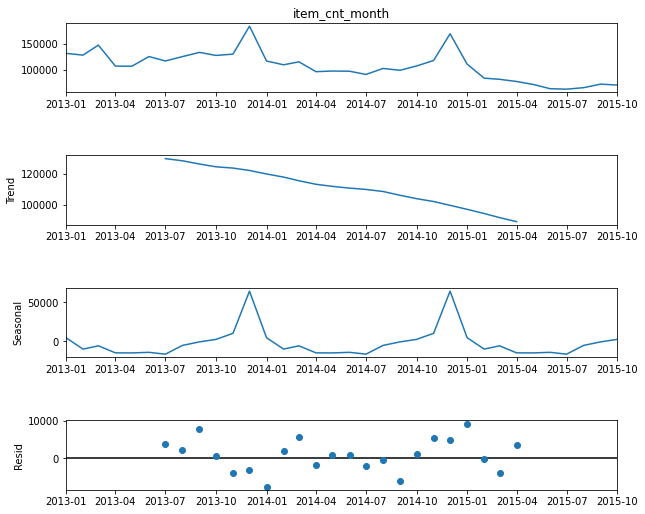

In [21]:
seasonal_decompose(dff_train['item_cnt_month'], model = 'additive').plot().set_size_inches(10, 8)

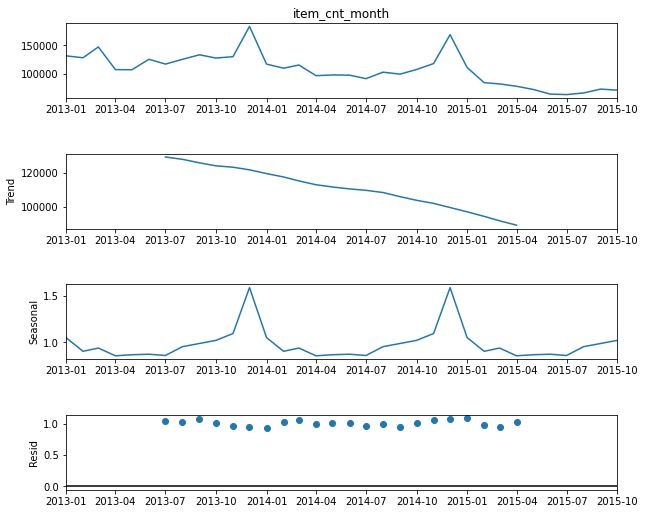

In [22]:
seasonal_decompose(dff_train['item_cnt_month'], model = 'multiplicative').plot().set_size_inches(10, 8)

In [5]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
df_test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [7]:
df_test.shape

(214200, 3)

In [9]:
df_test.columns

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [23]:
def adf_test(dataseries):
    adf = adfuller(dataseries)
    output = pd.Series(adf[0:3], index = ['ADF Statistic', 'p-value', 'Lags'])
    for key, value in adf[4].items():
        output["Critical Value (%s)" %key] = value
    
    return print(output)

In [24]:
adf_test(dff_train['item_cnt_month'])

ADF Statistic          -2.395704
p-value                 0.142953
Lags                    0.000000
Critical Value (1%)    -3.646135
Critical Value (5%)    -2.954127
Critical Value (10%)   -2.615968
dtype: float64


In [25]:
def order_parameters(training_data):
    
    search_params = auto_arima(training_data, start_p = 0, start_q = 0, m = 12, seasonal = True, test = "adf", d = None, trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, 
                    stepwise = True)
 
    print("AIC = ", round(search_params.aic(), 2))
                  
    return search_params

In [26]:
model = order_parameters(dff_train['item_cnt_month'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=448.765, Time=0.43 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=451.736, Time=0.05 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=449.440, Time=0.15 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=438.095, Time=0.25 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=439.392, Time=0.52 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=438.173, Time=0.25 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=440.703, Time=0.46 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=448.622, Time=0.05 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=451.418, Time=0.12 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=449.122, Time=0.07 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=inf, T

In [27]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -216.048
Date:                            Mon, 04 Jul 2022   AIC                            438.095
Time:                                    17:11:51   BIC                            441.082
Sample:                                         0   HQIC                           438.678
                                             - 34                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9856      0.298     -3.311      0.001      -1.569      -0.402
ma.S.L12      -0.0853      0.168   

In [28]:
prediction, confint = model.predict(n_periods = 6, return_conf_int = True) #95% CI default
df_confint = pd.DataFrame(confint)
print(confint.round(2))
print(prediction.round(2))

[[ 49454.95 106326.13]
 [ 84822.5  166627.74]
 [ 14725.65 116582.4 ]
 [-22076.08  97438.41]
 [-34511.53 101209.37]
 [-50584.33 100364.26]]
[ 77890.54 125725.12  65654.02  37681.17  33348.92  24889.97]


In [29]:
period_index = pd.period_range(start = dff_train.index[-1], periods = 6, freq='M')

df_predict = pd.DataFrame({'Predicted item_cnt_month': prediction.round(2)}, index = period_index)
print(df_predict)

         Predicted item_cnt_month
2015-10                  77890.54
2015-11                 125725.12
2015-12                  65654.02
2016-01                  37681.17
2016-02                  33348.92
2016-03                  24889.97


In [30]:
df_predict.head(2)

,Predicted item_cnt_month
2015-10,77890.54
2015-11,125725.12


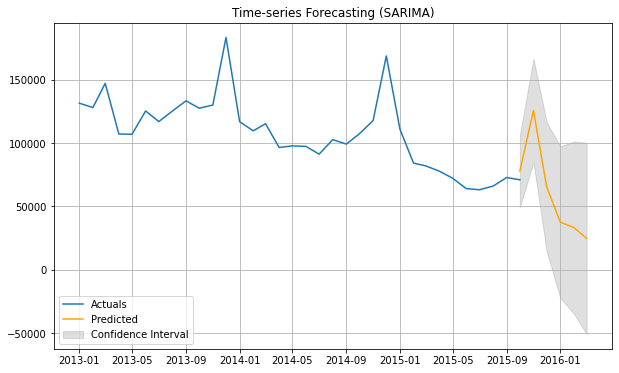

In [31]:
plt.figure(figsize = (10, 6))
plt.plot(dff_train['item_cnt_month'], label = 'Actuals')
plt.plot(df_predict.to_timestamp(), color = 'orange', label = 'Predicted')
plt.fill_between(period_index.to_timestamp(), df_confint[0], df_confint[1], color = 'grey', alpha = 0.25, label = 'Confidence Interval')
plt.legend(loc = 'lower left')
plt.title('Time-series Forecasting (SARIMA)')
plt.grid()
plt.show()

In [32]:
train_df_tuple = df_train.groupby(['shop_id', 'item_id'])['date', 'item_cnt_day'].agg({'item_cnt_day':'sum'})
train_df_tuple = train_df_tuple.reset_index()
print(train_df_tuple)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


        shop_id  item_id  item_cnt_day
0             0       30          31.0
1             0       31          11.0
2             0       32          16.0
3             0       33           6.0
4             0       35          15.0
...         ...      ...           ...
424119       59    22154           1.0
424120       59    22155           1.0
424121       59    22162          16.0
424122       59    22164           6.0
424123       59    22167           4.0

[424124 rows x 3 columns]


In [33]:
df_test['item_cnt_month'] = (prediction[0].round(2)*len(df_test)/len(train_df_tuple))/len(df_test)
#df_test['item_cnt_month'] = prediction[0]*len(df_test)/len(train_df_tuple)
submission  = df_test.drop(['shop_id', 'item_id'], axis = 1)
print(submission)

            ID  item_cnt_month
0            0         0.18365
1            1         0.18365
2            2         0.18365
3            3         0.18365
4            4         0.18365
...        ...             ...
214195  214195         0.18365
214196  214196         0.18365
214197  214197         0.18365
214198  214198         0.18365
214199  214199         0.18365

[214200 rows x 2 columns]


In [34]:
submission.to_csv('submission.csv', index = False)